# Prerequisites

In [2]:
!pip list | egrep -e "transformers|datasets|accelerate|peft|bitsandbytes|trl|torch|flash-attn|sentencepiece"

accelerate                        0.28.0             /home/g/accelerate_fork
bitsandbytes                      0.42.0
datasets                          2.18.0
flash-attn                        2.5.6
open-clip-torch                   2.23.0
peft                              0.9.0
pytorch-lightning                 1.9.4
sentence-transformers             2.3.1
sentencepiece                     0.2.0
torch                             2.2.1
torch-grammar                     0.3.3
torchaudio                        2.1.0
torchdiffeq                       0.2.3
torchmetrics                      1.2.0
torchsde                          0.2.6
torchtyping                       0.1.4
torchvision                       0.16.0
transformers                      4.38.2
trl                               0.7.11
trlx                              0.7.0


# 1 Simple example: similarity of single words
embedd a few simple words different meanings

## load embedding model

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

## embedd samples

In [2]:
# code taken from model card of sentence-transformers/all-mpnet-base-v2

# Sentences we want sentence embeddings for
sentences = ["lemon", "orange", "car", "money"]

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
tensor([[ 0.0398, -0.0315, -0.0107,  ...,  0.0002, -0.0352, -0.0136],
        [ 0.0116,  0.0079,  0.0351,  ...,  0.0365, -0.0294,  0.0150],
        [-0.0155,  0.0116,  0.0246,  ..., -0.0148, -0.0448, -0.0136],
        [ 0.0272,  0.0794,  0.0010,  ...,  0.0121,  0.0031, -0.0031]])


In [3]:
sentence_embeddings.shape

torch.Size([4, 768])

## calculate similarity 

In [4]:
for i in range(0, len(sentences)):
    print(
        sentences[0],
        sentences[i],
        (sentence_embeddings[0]@sentence_embeddings[i]).item()
    )    

lemon lemon 1.0000001192092896
lemon orange 0.5340331792831421
lemon car 0.29094189405441284
lemon money 0.2281380593776703


## PCA and plot in 2d-space

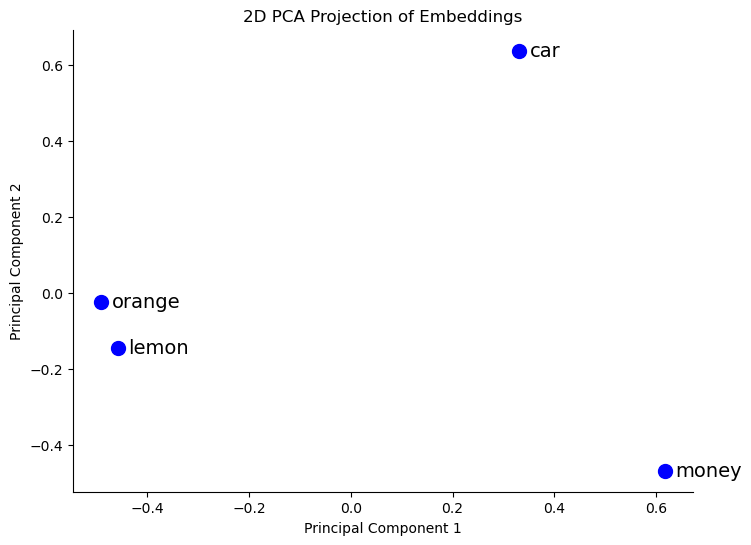

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA, reducing to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings
embeddings_2d = pca.fit_transform(sentence_embeddings)

# Plotting with labels for each data point
plt.figure(figsize=(8, 6))
for i, point in enumerate(embeddings_2d):
    plt.scatter(point[0], point[1], c='blue', edgecolor=None, s=100)
    plt.text(point[0] + 0.02, point[1] - 0.014, sentences[i], fontsize=14)

plt.title("2D PCA Projection of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.gca().spines['top'].set_visible(False)    # Hide top border
plt.gca().spines['right'].set_visible(False)    # Hide top border

plt.show()

# 2 Advanced example: embedd questions from public dataset
embedd all questions from Open Assistant 2 dataset (`g-ronimo/oasst2_top1_en`) and find most similar and dissimilar ones

## load dataset, extract first question

In [2]:
from datasets import load_dataset

dataset = load_dataset("g-ronimo/oasst2_top1_en")
questions = [ d["conversation"][0]["content"] for d in dataset["train"]]
len(questions)

5419

## embedd

In [1]:
from semscore import EmbeddingModelWrapper
em = EmbeddingModelWrapper()

In [3]:
sentence_embeddings = em.get_embeddings(questions)

100%|███████████████████████████████████████████████████| 678/678 [00:31<00:00, 21.68it/s]


In [5]:
sentence_embeddings

tensor([[-3.3470e-05,  1.6561e-01, -5.7893e-03,  ...,  5.2201e-02,
         -1.7394e-01, -2.5621e-02],
        [-2.4452e-02,  1.4669e-01,  7.0387e-03,  ...,  1.1961e-01,
          1.4565e-01, -9.3017e-02],
        [ 9.3027e-02,  9.1036e-02,  1.1242e-01,  ...,  3.2132e-02,
          9.6860e-02, -6.4952e-02],
        ...,
        [ 4.4400e-02, -1.1218e-01,  1.0112e-04,  ...,  1.1367e-01,
          6.9840e-02, -5.5423e-02],
        [-4.1723e-02,  3.6938e-01, -1.7017e-01,  ...,  3.6836e-03,
         -1.0425e-01, -8.1833e-02],
        [-1.1155e-01, -6.5667e-02, -6.2950e-02,  ..., -2.9471e-02,
          2.6846e-01,  2.9825e-02]], device='cuda:0')

## plot PCA projection for embedded questions

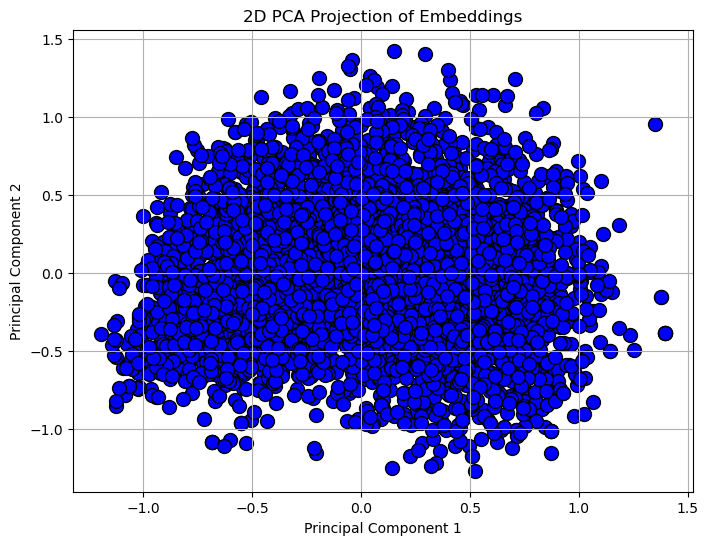

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA, reducing to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings
embeddings_2d = pca.fit_transform(sentence_embeddings.cpu())

# Plotting with labels for each data point
plt.figure(figsize=(8, 6))
for i, point in enumerate(embeddings_2d):
    plt.scatter(point[0], point[1], c='blue', edgecolor='k', s=100)

plt.title("2D PCA Projection of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

## find most similar and dissimilar questions

In [7]:
similarities = em.get_similarities(sentence_embeddings.cuda())

100%|███████████████████████████████████████████████| 5419/5419 [00:04<00:00, 1123.57it/s]


In [10]:
similarities

tensor([[ 1.0000, -0.0393,  0.0052,  ..., -0.0798,  0.0419, -0.0245],
        [-0.0393,  1.0000, -0.0195,  ..., -0.0081,  0.0820, -0.0474],
        [ 0.0052, -0.0195,  1.0000,  ...,  0.0373,  0.0902,  0.1156],
        ...,
        [-0.0798, -0.0081,  0.0373,  ...,  1.0000,  0.0968,  0.0040],
        [ 0.0419,  0.0820,  0.0902,  ...,  0.0968,  1.0000, -0.0662],
        [-0.0245, -0.0474,  0.1156,  ...,  0.0040, -0.0662,  1.0000]])

In [ ]:
import torch 

lower_triangle = torch.tril(similarities, diagonal=-1)

# Get the coordinates of the lower triangle elements
coords = torch.nonzero(lower_triangle, as_tuple=False)

# Flatten the lower triangle values
values = lower_triangle[lower_triangle != 0]

## find most similar

In [56]:
# Sort the values and get the sorted indices
sorted_indices = torch.argsort(values, descending=True)

# Sort values and coordinates using the sorted indices
sorted_values = values[sorted_indices]
sorted_coords = coords[sorted_indices]

# most similar
for i in range(len(questions)):
    similarity = sorted_values[i]
    q1idx, q2idx = sorted_coords[i].tolist()
    q1, q2 = questions[q1idx], questions[q2idx]
    if not q1.replace(" ","").lower() == q2.replace(" ", "").lower(): 
        print(similarity)
        print(q1)
        print()
        print(q2)       
        maxSimElement = [q1idx, q2idx]
        break

tensor(0.9987)
I want you to act as a Linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside a unique code block, and nothing else. Do no write explanations. Do not type commands unless I instruct you to do so. When I need to tell you something in English I will do so by putting text inside curly brackets {like this}. My first command is pwd.

I want you to act as a Linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. Do no write explanations. Do not type commands unless I instruct you to do so. When I need to tell you something in English I will do so by putting text inside curly brackets {like this}. My first command is pwd.


## find most dissimilar

In [57]:
# Sort the values and get the sorted indices
sorted_indices = torch.argsort(values, descending=False)

# Sort values and coordinates using the sorted indices
sorted_values = values[sorted_indices]
sorted_coords = coords[sorted_indices]

# most dissimilar
for i in range(len(questions)):
    similarity = sorted_values[i]
    q1idx, q2idx = sorted_coords[i].tolist()
    q1, q2 = questions[q1idx], questions[q2idx]
    if not q1.replace(" ","").lower() == q2.replace(" ", "").lower(): 
        print(similarity)
        print(q1)
        print()
        print(q2)       
        minSimElement = [q1idx, q2idx]
        break

tensor(-0.2590)
These are the books i like, suggest me more like these: The Handmaid's Tale by Margaret Atwood
A Fine Balance by Rohinton Mistry
Educated by Tara Westover
Eleanor Oliphant Is Completely Fine by Gail Honeyman
Essays In Love by Alain de Botton
A Man Called Ove by Fredrik Backman
In Five Years by Rebecca Serle
Little Fires Everywhere by Celeste Ng
Normal People by Sally Rooney
Room by Emma Donoghue

How would win in a battle between a Giant Tiranosaurius Rex and Godzilla?


# show most similar and dissimilar on PCA plot

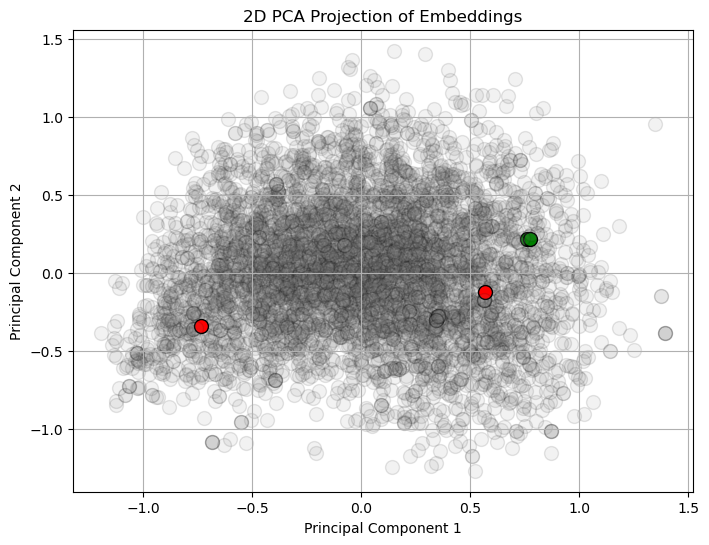

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA, reducing to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings
embeddings_2d = pca.fit_transform(sentence_embeddings.cpu())

# Plotting with labels for each data point
plt.figure(figsize=(8, 6))
for i, point in enumerate(embeddings_2d):
    col="grey"
    alpha=0.1
    
    if i in maxSimElement:
        col="green"
        alpha=1
    elif i in minSimElement:
        col="red"
        alpha=1
    
    plt.scatter(point[0], point[1], c=col, alpha=alpha, edgecolor='black', s=100)

plt.title("2D PCA Projection of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()